In [51]:
import numpy as np
import pandas as pd
import re
import nltk
import nltk.data
from tqdm import tqdm
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\genas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
news = pd.DataFrame(pd.read_csv('hrefs.CSV'), columns=['title', 'text'])
news

,title,text
0,"В МИД Японии заявили, что страна предоставила ...",\nВласти Японии к настоящему времени предостав...
1,Белгородская область подверглась новой атаке б...,"\nНочью в среду, 24 мая, в Белгородской област..."
2,Климатолог рассказал о сезоне ураганов в Москве,\nВ столичном регионе в конце мая – начале июн...
3,Российский холдинг Segezha Group продал европе...,\nРоссийский лесопромышленный холдинг Segezha ...
4,"Жители Москвы могут выбрать цвета, которыми об...",\nЖители Москвы могут проголосовать за одну из...
...,...,...
403,Лидеры G7 договорились продолжить поддержку Ук...,\nПравительство России расширило доступ произв...
404,"В кабмине ожидают, что рынок БПЛА в России по ...","\nЛидеры государств, входящих в ""Большую семер..."
405,РИА Новости: в России средний размер автокреди...,\nNikkei: Япония запретит предоставлять России...
406,ВСУ обстреляли село Муром Белгородской области,\nИтальянский ракетный эскадренный миноносец п...


In [9]:
def text_to_sentences(text):
    """ Функция делит текст на предложения, а предложения на слова.
    """
    
    # Поделим текст на предложения при помощи NLTK.
    raw_sentences = nltk.sent_tokenize(text, language="russian")
    # Поделим предложения на слова при помощи регулярных выражений, заодно выкинем знаки препинания и цифры.
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.findall('[a-zA-Zа-яА-яёЁ]+', raw_sentence.lower()))
    return sentences

In [11]:
text_to_sentences(news['text'][11])

[['в',
  'столичном',
  'регионе',
  'в',
  'конце',
  'мая',
  'начале',
  'июня',
  'чаще',
  'всего',
  'фиксируются',
  'шквалистые',
  'ветры',
  'и',
  'ураганы',
  'однако',
  'на',
  'данный',
  'момент',
  'погода',
  'спокойная'],
 ['об',
  'этом',
  'в',
  'среду',
  'мая',
  'рассказал',
  'замдиректора',
  'института',
  'физики',
  'атмосферы',
  'имени',
  'обухова',
  'российской',
  'академии',
  'наук',
  'владимир',
  'семенов'],
 ['вторая',
  'половина',
  'мая',
  'и',
  'первая',
  'половина',
  'июня',
  'это',
  'время',
  'когда',
  'наиболее',
  'сильный',
  'температурный',
  'контраст',
  'между',
  'северными',
  'морями',
  'и',
  'европейской',
  'частью',
  'россии'],
 ['поэтому',
  'если',
  'случаются',
  'холодные',
  'вторжения',
  'то',
  'именно',
  'в',
  'это',
  'время',
  'чаще',
  'всего',
  'бывают',
  'шквалы',
  'сильный',
  'порывистый',
  'ветер',
  'как',
  'в',
  'году',
  'было',
  'в',
  'москве',
  'пояснил',
  'специалист',
  'в',
 

In [12]:
news['text'][11]

'\nВ столичном регионе в конце мая – начале июня чаще всего фиксируются шквалистые ветры и ураганы, однако на данный момент погода спокойная. Об этом в среду, 24 мая, рассказал замдиректора Института физики атмосферы имени Обухова Российской академии наук Владимир Семенов.\n"Вторая половина мая и первая половина июня – это время, когда наиболее сильный температурный контраст между северными морями и европейской частью России. Поэтому если случаются холодные вторжения, то именно в это время чаще всего бывают шквалы, сильный порывистый ветер, как в 2017 году было в Москве", – пояснил специалист в беседе с агентством городских новостей "Москва".\nПри этом пока что погода в столице дождливая, а сильной жары не было. В связи с этим в ближайшие несколько дней ураганов не будет. Обычно их следует ждать после периода жаркой погоды, когда воздух наполняется влагой, заключил Семенов.\nСогласно прогнозам метеорологов, в ближайшие выходные в Москву придет похолодание. А метеорологическое лето в ст

In [13]:

all_sentences = sum([text_to_sentences(x) for x in news['text']], [])

In [14]:
all_sentences[0]

['власти',
 'японии',
 'к',
 'настоящему',
 'времени',
 'предоставили',
 'украине',
 'гуманитарной',
 'и',
 'финансовой',
 'помощи',
 'на',
 'общую',
 'сумму',
 'млрд',
 'сообщил',
 'мая',
 'глава',
 'мид',
 'японии',
 'ёсимаса',
 'хаяси',
 'в',
 'ходе',
 'обсуждения',
 'бюджета',
 'в',
 'палате',
 'представителей',
 'нижняя',
 'палата',
 'парламента']

In [16]:
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

In [44]:
model_w2v = KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec.gz')

In [19]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [23]:
model_w2v.most_similar('город_NOUN')

[('столица_NOUN', 0.6747552156448364),
 ('грод_NOUN', 0.6577627658843994),
 ('городок_NOUN', 0.6478427052497864),
 ('пригород_NOUN', 0.6212136149406433),
 ('мегаполис_NOUN', 0.6159499883651733),
 ('городый_ADJ', 0.6062526106834412),
 ('город-герой_NOUN', 0.604307234287262),
 ('город-спутник_NOUN', 0.6018998622894287),
 ('населенный_ADJ', 0.5992230772972107),
 ('городишко_NOUN', 0.5902962684631348)]

In [24]:
list(model_w2v.key_to_index.keys())[:20]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN']

In [25]:
lens = np.array([np.linalg.norm(model_w2v[word]) for word in model_w2v.key_to_index.keys()])
lens[lens > 1.01], lens[lens < 0.99], lens[0]

(array([], dtype=float32), array([], dtype=float32), 0.9999996)

In [26]:
model_w2v.most_similar(positive=[u'сербия_PROPN', u'москва_PROPN' ], negative=[u'белград_PROPN'])

[('россия::москва_PROPN', 0.7317757606506348),
 ('россия_PROPN', 0.7260456681251526),
 ('москва::москва_PROPN', 0.7081453204154968),
 ('москва::россия_PROPN', 0.6551341414451599),
 ('россия::санкт-петербург_PROPN', 0.6160128712654114),
 ('рф::москва_PROPN', 0.6140520572662354),
 ('рязань_PROPN', 0.6115250587463379),
 ('россия::украина_PROPN', 0.6086370944976807),
 ('белоруссия_PROPN', 0.6031982898712158),
 ('москва::санкт-петербург_PROPN', 0.6031042337417603)]

In [29]:
import umap
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [37]:
def get_most_frequent_words_from_model(model, texts, threshold=10):
    """ Функция выделяет слова, которые встречаются в текстах texts не реже, чем threshold раз,
        и при этом имеются в предобученной модели model. Также возвращает вектора этих слов.
    """
    vctr = CountVectorizer(lowercase=False)
    cntr = vctr.fit_transform(texts)
    
    res_words = []
    res_vects = []
    summed = cntr.sum(axis=0)
    klist = list(vctr.vocabulary_.keys())
    for i in range(summed.shape[1]):
        if summed[0, i] > threshold:
            try:
                res_vects.append(model[klist[i]])
                res_words.append(klist[i])
            except:
#                 print(klist[i])
                pass
    
    return res_words, res_vects

In [49]:
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy3.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [52]:
sci_sentences = []
n_texts = []
for text in tqdm(news['text']):
    norm = normalizePymorphy(text)
    sci_sentences.append(norm)
    n_texts.append(' '.join(norm))

100%|██████████| 408/408 [00:01<00:00, 285.41it/s]


In [54]:
news['text'] = n_texts
news['text']

0      власть_NOUN япония_NOUN настоящий_ADJ время_NO...
1      среда_NOUN май_NOUN белгородский_ADJ область_N...
2      столичный_ADJ регион_NOUN конец_NOUN май_NOUN ...
3      российский_ADJ лесопромышленный_ADJ холдинг_NO...
4      житель_NOUN москва_NOUN мочь_VERB один_ADJ пре...
                             ...                        
403    правительство_NOUN россия_NOUN расширить_VERB ...
404    лидер_NOUN государство_NOUN входящий_ADJ больш...
405    япония_NOUN запретить_VERB россия_NOUN строите...
406    итальянский_ADJ ракетный_ADJ эскадренный_ADJ м...
407    юго-восток_NOUN москва_NOUN мужчина_NOUN зайти...
Name: text, Length: 408, dtype: object

In [84]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice
from umap.umap_ import UMAP


In [71]:
def cluster_texts_and_draw(vectors, umaped_vct, eps):
    """ Функция кластеризует вектора vectors при помощи DBSCAN, используя eps в качестве параметра,
        и отображает их на плоскость, используя umaped_vct.
    """
    # Кластеризуем данные при помощи DBSCAN. 
    # Это не значит, что он лучше k-Means, он просто здесь быстрее.
    db = DBSCAN(eps=eps, min_samples=3)
    db_clusters = db.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1))
    print(max(db_clusters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
    plt.show()
    return db_clusters

def show_texts_in_clusters(texts, target, clust_no, text_no):
    """ Функция отображает группировку текстов texts по кластсерам target.
        Выводит не более text_no текстов из первых clust_no кластеров.
    """

    clusters = list(set(target))

    for c in clusters[:clust_no]:
        print('          __ ', c, ' __')
        cntr = 0
        for i, a in enumerate(texts):
            if target[i] == c:
                print(a[:200])
                cntr += 1
                if cntr == text_no:
                    break
        print()
        
    

In [55]:

news_words, news_vects = get_most_frequent_words_from_model(model_w2v, news['text'], 10)

In [56]:
len(news_words)

730

In [57]:
len(news_vects)

730

In [60]:
sci_clust_no = int(len(news_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
sci_clusters = km_clustering.fit_predict(news_vects)

C:\Users\genas\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
coi = 1
[word for word, clust in zip(news_words, sci_clusters) if clust == coi]

['взрывчатка_NOUN', 'самодельный_ADJ', 'смертоносный_ADJ']

In [64]:
news_words_sorted = sorted(zip(sci_clusters, news_words), key= lambda x:x[0])
# sci_set = set(sci_words)
news_words_d = {w[1]:w[0] for w in news_words_sorted}

In [65]:
clust_no = 22
print([word[1] for word in news_words_sorted if word[0]==clust_no])

['разработчик_NOUN', 'программист_NOUN', 'функционал_NOUN']


In [66]:
# Посчитаем координаты центроидов.
cur_clust = news_words_sorted[0][0]
cur_coord = np.array(model_w2v[news_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(news_words_sorted[1:]):
    if cur_clust == news_words_sorted[i+1][0]:
        cur_coord += model_w2v[news_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = news_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[news_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)

In [67]:
def text_to_vec_centr(text, model_w2v, clust_coord, sci_words_d):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in sci_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[sci_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [82]:
# Строим вектора для слов.
news_vect2 = []
for text in tqdm(news.text):
    news_vect2.append(text_to_vec_centr(text, model_w2v, clust_coord, news_words_d))

100%|██████████| 408/408 [00:00<00:00, 578.85it/s]


0


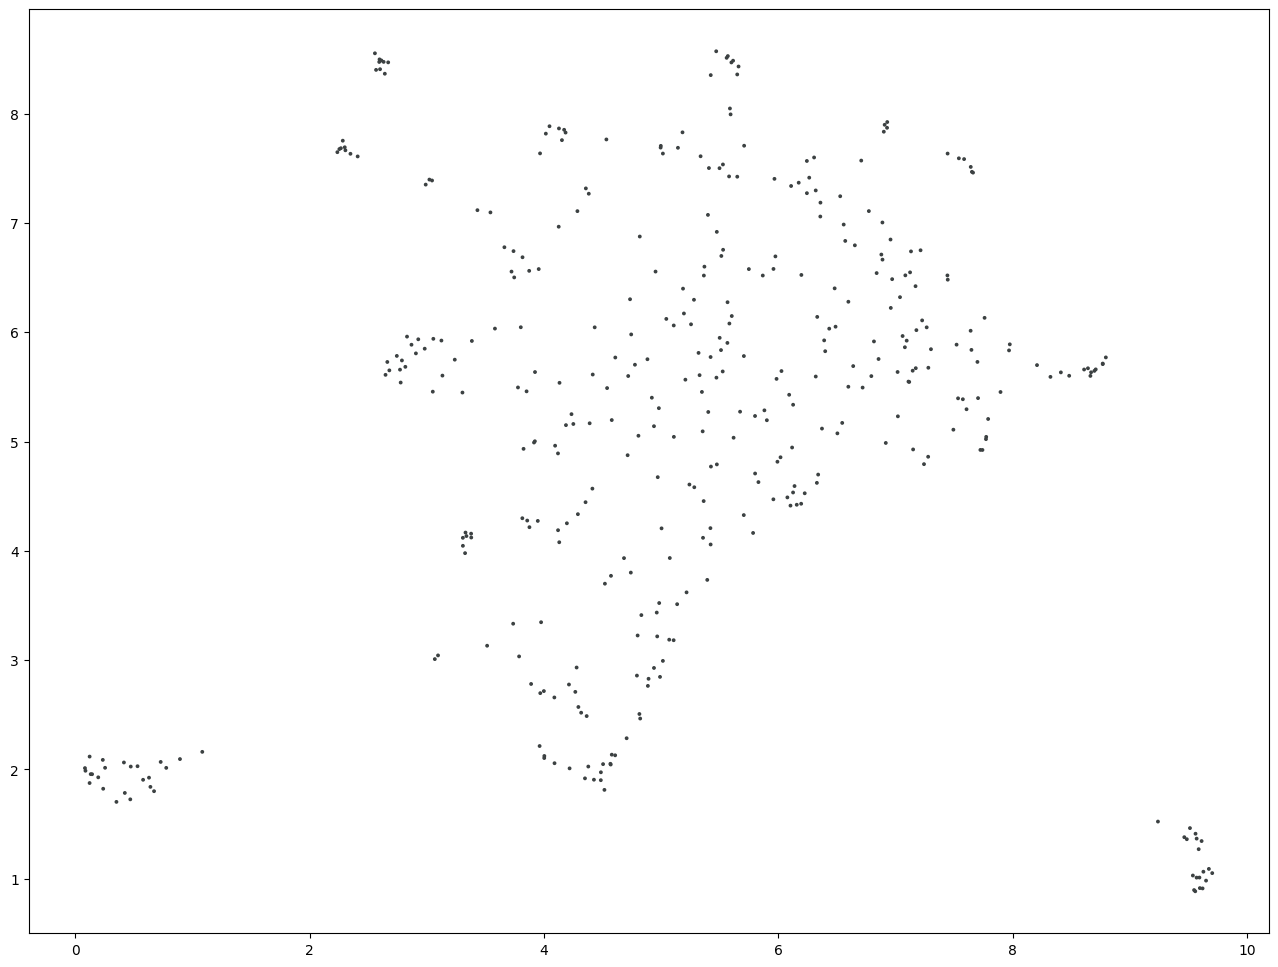

In [85]:
umaped_vct2 = UMAP().fit_transform(news_vect2)
clusters = cluster_texts_and_draw(news_vect2, umaped_vct2, 0.09)

In [89]:
show_texts_in_clusters(news.text, clusters, 10, 3)

          __  0  __
среда_NOUN май_NOUN столичный_ADJ регион_NOUN ожидаться_VERB облачный_ADJ погода_NOUN пройти_VERB дождь_NOUN отдельный_ADJ район_NOUN вероятный_ADJ гроза_NOUN температура_NOUN воздух_NOUN день_NOUN мо
вторник_NOUN май_NOUN житель_NOUN столичный_ADJ регион_NOUN ожидать_VERB облачный_ADJ прояснение_NOUN погода_NOUN пройти_VERB кратковременный_ADJ дождь_NOUN место_NOUN вероятный_ADJ гроза_NOUN темпера
понедельник_NOUN май_NOUN москва_NOUN подмосковье_NOUN прогнозироваться_VERB облачный_ADJ погода_NOUN прояснение_NOUN возможный_ADJ небольшой_ADJ дождь_NOUN место_NOUN умеренный_ADJ некоторый_ADJ райо

          __  -1  __
власть_NOUN япония_NOUN настоящий_ADJ время_NOUN предоставить_VERB украина_NOUN гуманитарный_ADJ финансовый_ADJ помощь_NOUN общий_ADJ сумма_NOUN млрд_NOUN сообщить_VERB май_NOUN глава_NOUN мид_NOUN яп
среда_NOUN май_NOUN белгородский_ADJ область_NOUN быть_VERB зафиксировать_ADJ большой_ADJ количество_NOUN атака_NOUN беспилотник_NOUN большинство_NOUN спр

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [91]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

In [104]:
classes = np.ones(408)
for i in range(2, 6):
    classes[(i-1)*82: i*82] = i  

In [105]:
classes

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

In [106]:

classify_texts(news_vect2, classes)

accuracy = 0.35365853658536583
[[5 1 4 3 3]
 [5 5 1 0 2]
 [2 4 6 1 3]
 [1 5 2 6 7]
 [2 3 2 2 7]]
